In [1]:
import argparse
import os
import sys
import torch
import torch.nn as nn

import datasets
import models.resnet as ResNet
import models.senet as SENet
from liveview import LiveView
import utils

configurations = {
    1: dict(
        max_iteration=1000000,
        lr=1.0e-1,
        momentum=0.9,
        weight_decay=0.0,
        gamma=0.1, # "lr_policy: step"
        step_size=1000000, # "lr_policy: step"
        interval_validate=1000,
    ),
}

def get_parameters(model, bias=False):
    for k, m in model._modules.items():
        if k == "fc" and isinstance(m, nn.Linear):
            if bias:
                yield m.bias
            else:
                yield m.weight

N_IDENTITY = 8631  # the number of identities in VGGFace2 for which ResNet and SENet are trained

parser = argparse.ArgumentParser("PyTorch Face Recognizer")
parser.add_argument('--arch_type', type=str, default='resnet50_ft', help='model type',
                    choices=['resnet50_ft', 'senet50_ft', 'resnet50_scratch', 'senet50_scratch'])
parser.add_argument('--log_file', type=str, default='/path/to/log_file', help='log file')
parser.add_argument('--checkpoint_dir', type=str, default='/path/to/checkpoint_directory',
                    help='checkpoints directory')
parser.add_argument('--feature_dir', type=str, default='/path/to/feature_directory',
                    help='directory where extracted features are saved')
parser.add_argument('-c', '--config', type=int, default=1, choices=configurations.keys(),
                    help='the number of settings and hyperparameters used in training')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--resume', type=str, default='', help='checkpoint file')
parser.add_argument('--weight_file', type=str, default='./resnet50_ft_weight.pkl', help='weight file')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--horizontal_flip', action='store_true',
                    help='horizontally flip images specified in test_img_list_file')

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
cuda = torch.cuda.is_available()
if cuda:
    print("torch.backends.cudnn.version: {}".format(torch.backends.cudnn.version()))

torch.manual_seed(1337)
if cuda:
    torch.cuda.manual_seed(1337)

# 2. model
include_top = True
model = ResNet.resnet50(num_classes=N_IDENTITY, include_top=include_top)

# print(model)

start_epoch = 0
start_iteration = 0

resume = False
if resume:
    checkpoint = torch.load(resume)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']
    start_iteration = checkpoint['iteration']
    assert checkpoint['arch'] == 'resnet50_ft'
    print("Resume from epoch: {}, iteration: {}".format(start_epoch, start_iteration))
else:
    utils.load_state_dict(model, './resnet50_ft_weight.pkl')

if cuda:
    model = model.cuda()


print("MODEL LOADED!")

torch.backends.cudnn.version: 7401
MODEL LOADED!


In [2]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.ToTensor(),
   normalize
])

def FeatureGeneration(model,targets):
    target_features = []

    for target in targets:
      batch = [preprocess(perspective).cuda() for perspective in target ]
      batch = t.stack(batch)
      target_features.append(model(batch))
    
    return target_features

In [3]:
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline


In [49]:
def correlate(space,face):
    torch.cuda.empty_cache()
    face_features   = FeatureGeneration(feat_gen,[[face]])[0]
    search_features = FeatureGeneration(feat_gen,[[space]])[0]
    output = (F.conv2d(search_features, face_features).squeeze(0)).squeeze(0).detach().cpu().numpy()
    return output

def process(space,face):
    output = correlate(space,face)
    h,w = output.shape
    plt.imshow(output)
    pos = np.argmax(output)
    o_h,o_w = output.shape
    idx = (pos // o_w), (pos%o_w)
    py,px = (pos // o_w)/h, (pos%o_w)/w
    h_0,w_0,c_0 = target.shape
    tr_y,tr_x = int(h_0 * py), int(w_0 * px)
    return tr_y,tr_x

def draw_bb(target,tr_y,tr_x):
    for w in range(5):
        for x in range(244):
            target[tr_y-w    ,tr_x-x    ] = [255,0,0]
            target[tr_y+244+w,tr_x-x    ] = [255,0,0]    
        for y in range(244):
            target[tr_y+y    ,tr_x+w    ] = [255,0,0]
            target[tr_y+y    ,tr_x-244-w] = [255,0,0]    
    plt.imshow(target)
    ex = target[tr_y:tr_y+244,tr_x-244:tr_x]
    return ex

In [196]:
feat_gen = nn.Sequential(*list(model.children())[:-4])

(244, 244, 3)


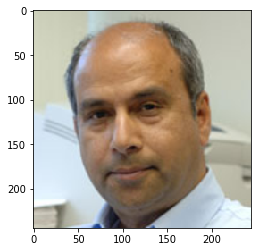

In [197]:
shah = np.array(Image.open("Data/Dr_Shah.jpg"))
shah = shah[:175,25:200]
plt.imshow(shah)
shah = Image.fromarray(shah)
shah = shah.resize((244,244),Image.BILINEAR)
shah = np.array(shah)
plt.imshow(shah)
print(shah.shape)

(698, 1586, 3)


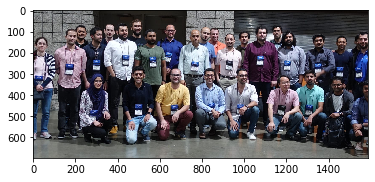

In [198]:
target = Image.open("Data/cvpr2019.jpg")
target = np.array(target)
print(target.shape)
plt.imshow(target)

(1050, 2000, 3)


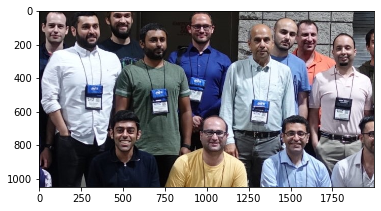

In [199]:
# Resizing up, factor of 3. 2100,4800. 
target = Image.open("Data/cvpr2019.jpg")
target = target.resize((4800,2100),Image.BILINEAR)
target = np.array(target)
target = target[200:1250,1000:3000]
print(target.shape)
plt.imshow(target)

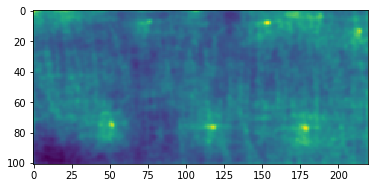

In [200]:
tr_y,tr_x = process(target,shah)

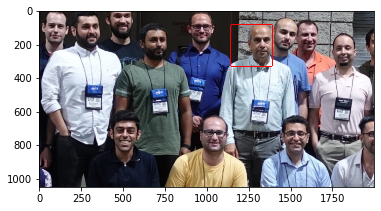

In [201]:
ex = draw_bb(target,tr_y,tr_x)

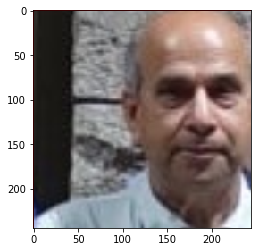

In [202]:
plt.imshow(ex)

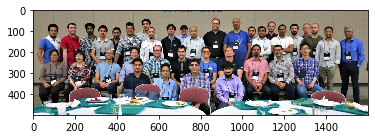

In [203]:
target2 = Image.open("Data/cvpr2018-group-1600x500.jpg")
plt.imshow(target2)

(50, 50, 3)


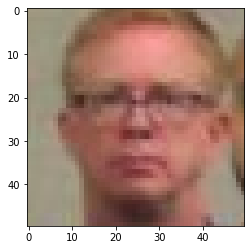

In [204]:
targetn=np.array(target2)
targetn=targetn[65:115,1280:1330]
print(targetn.shape)
plt.imshow(targetn)

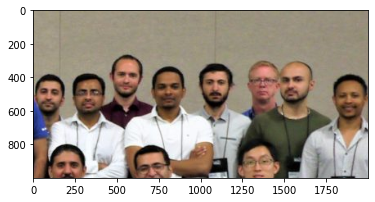

In [205]:
f = 244/50
h,w,c = np.array(target2).shape
h,w = int(h*f),int(w*f)
targetr=target2.resize((w,h),Image.BILINEAR)
targetr = np.array(targetr)
targetr = targetr[0:1000,5000:7000]
plt.imshow(targetr)

(244, 244, 3)


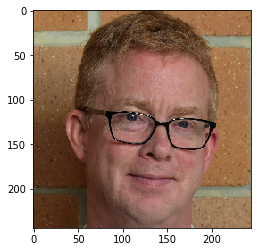

In [206]:
ex2 = Image.open("Data/Bruce_McIntosh-e1555693226946.jpg")
ex2 = np.array(ex2)[250:1800,550:2100]
ex2 = np.array(Image.fromarray(ex2).resize((244,244)))
print(ex2.shape)
plt.imshow(ex2)

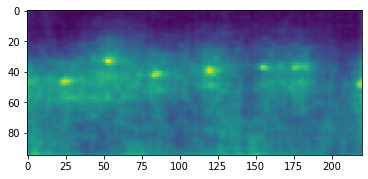

In [207]:
tr_y,tr_x = process(targetr,ex2)

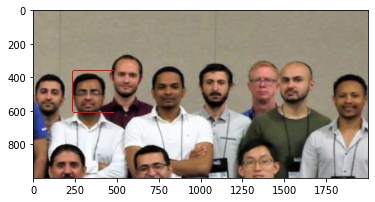

In [208]:
ex = draw_bb(targetr,tr_y,tr_x)

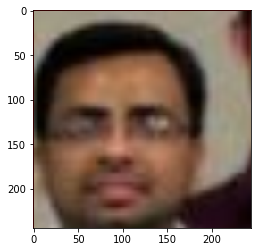

In [209]:
plt.imshow(ex)

(244, 244, 3)


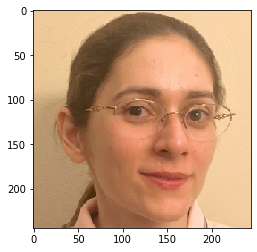

In [210]:
ex3 = Image.open("Data/MarziehEdraki.jpg")
ex3 = np.array(ex3)[10:330]
ex3 = np.array(Image.fromarray(ex3).resize((244,244)))
print(ex3.shape)
plt.imshow(ex3)

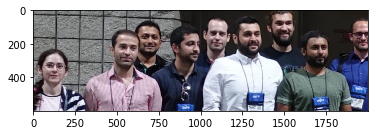

In [211]:
target = Image.open("Data/cvpr2019.jpg")
target = target.resize((4800,2100),Image.BILINEAR)
target = np.array(target)[150:750,:2000]
plt.imshow(target)

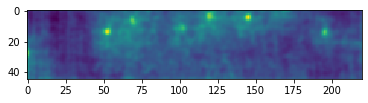

In [212]:
tr_y,tr_x = process(target,ex3)

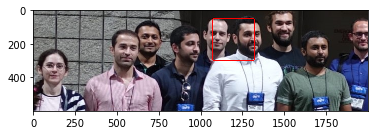

In [213]:
ex = draw_bb(target,tr_y,tr_x)

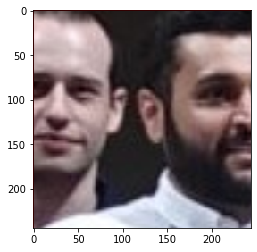

In [214]:
plt.imshow(ex)

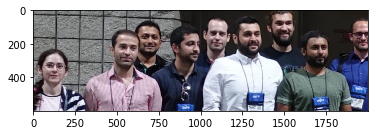

In [215]:
target = Image.open("Data/cvpr2019.jpg")
target = target.resize((4800,2100),Image.BILINEAR)
target = np.array(target)[150:750,:2000]
plt.imshow(target)

(244, 244, 3)


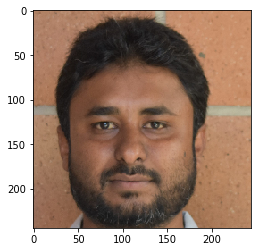

In [216]:
ex4 = Image.open("Data/junaid-e1555693537299.jpg")
ex4 = np.array(ex4)[220:2050,900:2730]
ex4 = np.array(Image.fromarray(ex4).resize((244,244)))
print(ex4.shape)
plt.imshow(ex4)

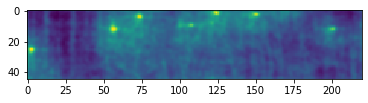

In [217]:
tr_y,tr_x = process(target,ex4)

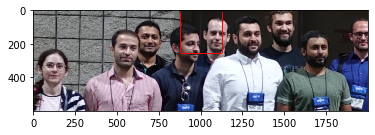

In [218]:
ex = draw_bb(target,tr_y,tr_x)